# Chapter 3: Approximation

In [1]:
%reload_ext Cython
import numpy as np
from numpy import linalg as nla
import pylab as plt
%matplotlib inline

## Interpolation

$$\renewcommand{\R}{\mathbb{R}}$$

* functions in chapter 1:
    * evaluation of function values $f(x)$ and $Ax$
    * approximation of real numbers and arithmetic expressions
* functions in chapter 2: 
    * computing zeros $x^*$ of functions, i.e., solution of equations $Ax = b$ and $f(x) = 0$
    * using functions $F(x)$ for iterative methods $x^{(k+1)} = F(x^{(k)})$
    * approximation of zeros $x^*$
* chapter 3: 
    * approximation of functions $u(x)$ by simpler functions, in particular polynomials

## Functions in scientific computing

* functions are not only arithmetic expressions
* they may solve complicated equations and usually are not known explicitely
    * they need to be approximated
    * these approximations are then used for predictions, diagnosis and decisions
* some functions are univariate, and for example depend on time
    * average temperature, blood pressure
* other functions vary spatially
    * hyper-spectrum of pasture or forest
    * flow speeds of water in ocean
* many functions also depend on various parameters
    * flow through soil and rocks depends on density and other paramters
* some functions are random

--------------------------------------------------------------------------------------
* fundamentally, a function is a mapping $u : X \rightarrow Y$ with domain $X$ and range $Y$

* here we will mostly consider $X=\R^d$ and $Y=\R$

* there are now a variety of ways on how to determine a function.

    * they may be specified by a formula like  $u(x) = \exp(-2x)$.

    * they may be defined implicitely, as the solution of some partial differential equation like $\Delta u = f$

    * one may only have partial and indirect information (measurements) of a function

   * some functions satisfy equations with unknown parameters which may be determined from observations



## Functions in Python

* one-liners using lambda

```python
    u = lambda x : x*x
```    
    
* Python procedures

```python
    def u(x):
      y = x*x
      return y
```    
    
* imported from Python modules

```python
    from math import exp
```

# Polynomial evaluation

## Polynomials, their representation and evaluation

* mathematical form of polynomial
$$p_n(x) = a_0 + a_1 x + \cdots + a_n x^n$$

* simple python code
```python
    def pn(x,a):
      y = 0.0
      n = a.shape[0]
      for k in range(n):
        y += a[k]*x**k
      return y
```

-----------------------------------------------------------

In [2]:
# timing polynomial evaluation
def pn(x,a):
    y = 0.0
    n = a.shape[0]
    for k in range(n):
        y  += a[k]*x**k
    return y

In [3]:
%%timeit 
from numpy.random import random, seed; 
n= 200; x = random();a = random(n)
y = pn(x,a) # timing polynomial

1000 loops, best of 3: 423 µs per loop


## Using Cython to be faster

In [4]:
%%cython
import cython
cimport cython
# timing polynomial evaluation
def pc0(x,a):
    y = 0.0
    n = a.shape[0]
    for k in range(n):
        y  += a[k]*x**k
    return y

In [5]:
%%timeit 
from numpy.random import random, seed; 
n= 200; x = random();a = random(n)
y = pc0(x,a) # timing polynomial

1000 loops, best of 3: 336 µs per loop


--------------------------------------

## Typing

* Python uses *dynamic typing*, where the type of each object is determined at run time
* C uses *static typing*, the type of each object needs to be specified explicitely
* Cython can do both but dynamic typing may prevent code optimisation
    * for efficient code, type all objects explicitely except where one actually requires dynamically typed
        objects

-------------------

In [6]:
%%cython 
cimport numpy as np
def pnc(np.float64_t x,\
        np.ndarray[np.float64_t, ndim=1] a):
    cdef int k
    cdef int n = a.shape[0]
    cdef np.float64_t y = 0
    for k in range(n):
        y  += a[k]*x**k
    return y

In [7]:
%%timeit
from numpy.random import random; n= 200;\
      x = random(); a = random(n)
y = pnc(x,a) # timing polynomial

10000 loops, best of 3: 62.8 µs per loop


## how to get faster code

* computational hardware costs substantially reduced in recent years
* code transformations used by compilers to get faster code
* faster code often by exploiting the *distributive law*
   $$(a + b) c = ac + bc$$
* application to polynomial evaluation: *Horner's rule*

   $$p_n(x) = a_0 + x(a_1 + x(a_2 + x(a_3+\cdots)))$$
   
--------------------------------------------------

In [8]:
# fast polynomial evaluation with Horner's method

def pnh(x,a):
    n = a.shape[0]
    y = 0.0
    for k in range(n):
        y  = x*y + a[n-k-1]
    return y

In [9]:
%%timeit 
from numpy.random import random, seed; 
n= 200; x = random(); a = random(n)
y = pnh(x,a) 

1000 loops, best of 3: 184 µs per loop


-----------------------------------------------------------------------------------

In [10]:
%%cython
import numpy as np
cimport numpy as np

# two versions: pnc for scalar x and png for vector xg

def pnc(np.float64_t x, np.ndarray[np.float64_t, ndim=1] a):
    cdef int k
    cdef int n = a.shape[0]
    cdef np.float64_t y = 0
    for k in range(n):
        y  = x*y + a[n-k-1]
    return y


-------------------------

In [11]:
%%cython
import numpy as np
cimport numpy as np

from __main__ import pnc

def png(np.ndarray[np.float64_t, ndim=1] xg, np.ndarray[np.float64_t,ndim=1] a, p=pnc):
    cdef int k
    cdef int ng = xg.shape[0]
    cdef int n  = a.shape[0]
    cdef np.ndarray[np.float64_t, ndim=1] yg = np.zeros(ng)
    for i in range(ng):
        for k in range(n):
            yg[i] = xg[i]*yg[i] + a[n-k-1]
    return yg

------------------------------------

In [12]:

# testing
from numpy.random import random
n=200; x = random(); a = random(n)
print(pnc(x,a)-pnh(x,a))

0.0


In [13]:
%%timeit
from numpy.random import random; 
n= 200; x = random(); a = random(n)
y = pnc(x,a) # timing polynomial

10000 loops, best of 3: 32.3 µs per loop


## Polynomial approximation and the Taylor polynomial

**Weierstrass' theorem**

*Every continuous function over a finite interval can be approximated arbitrarily well by a polynomial of sufficiently high degree.*

* we do not know in advance how high the degree has to be
* polynomial approximation works well for very smooth functions
* no quantitative error bound
* several proofs, including one using probability theory!

**Taylor remainder theorem**
*If $u(x)$ is $n+1$ times continuously differentiable in $[a,b]$ then for all $x\in[a,b]$ there exists
a $\xi\in [a,b]$ such that*

$$\begin{split}u(x) = u(a) + u^\prime(a) (x-a) + \frac{u^{\prime\prime}(a)}{2} (x-a)^2 + \cdots +
          \frac{u^{(n)}(a)}{n!} (x-a)^n \\ + \frac{u^{(n+1)}(\xi)}{(n+1)!} (x-a)^{n+1}\end{split}$$ 
          
------------------------------------------------------
          
* if $|u^{(n+1)}(x)| \leq C$ for all $x\in[a,b]$ then error of Taylor polynomial is bounded by
$$C\frac{(b-a)^{n+1}}{(n+1)!}$$

--------------------------------------------------------------

In [14]:
# Taylor series  y = sin(x) around x=0

from math import pi
n = 6
# compute taylor coefficients
taycoeff        = np.ones(n)
taycoeff[::2]   =  0
taycoeff[3::4] *= -1
taycoeff[1:]   /= np.cumprod(np.arange(1,n))
uex  = np.sin
ut = lambda x, a=taycoeff, p = png: p(x, a) # taylor approximation

xg = np.linspace(-2*pi,2*pi,128)
yg = np.sin(xg)
print('time for evaluation:')
%timeit -r 1 ygt = ut(xg)
ygt = ut(xg)

time for evaluation:
The slowest run took 12.68 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 1: 39.2 µs per loop


--------------------------------------------------------------------------------------------

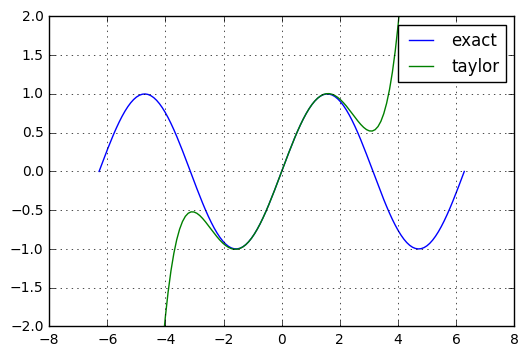

In [15]:
plt.grid('on'); plt.axis(ymin = -2, ymax = 2)
plt.plot(xg,yg, label="exact"); plt.plot(xg, ygt, label="taylor");plt.legend();

# Polynomial Interpolation

## Collocation

**Proposition**

*There is exactly one polynomial $p_n$ of degree $n$ which satisfies the interpolation conditions $$p_n(x_k) = y_k, \quad k=0,\ldots,n$$ if all $x_k$ are distinct*

**Proof**
by construction, will give 3 different approaches below which choose three different sets of basis functions for the linear space of polynomials of degree $n$

## Approach 1: power basis $x^k$

* if $p_n(x) =a_0+a_1x+\cdots+a_{n}x^n$, then the interpolation conditions lead to a linear system of
   equations for the $a_k$:
$$\left[\begin{array}{ccccc}
1&x_0&x_0^2&\cdots&x_0^{n}\\
1&x_1&x_1^2&\cdots&x_1^{n}\\
\vdots&\vdots&\vdots&&\vdots\\
1&x_{n}&x_n^2&\cdots&x_{n}^{n}
\end{array}\right]
\left[\begin{array}{c}
a_0\\a_1\\\vdots\\a_n\end{array}\right]
=\left[\begin{array}{c}
y_0\\y_1\\\vdots\\y_n\end{array}\right]$$

* the matrix $X$ of this system is a *Vandermonde matrix*
* **Proposition:** if no two $x_k$ are the same then $X$ is invertible

## Example:  linear interpolation

## Example

* $p_2(x) = a_0 + a_1 x + a_2 x^2$
* collocation points

|  $i$  |  0  |  1  |   2  |
|:-----:|:---:|:---:|:----:|
| $x_i$ |  0  | 0.5 |   2  |
| $y_i$ | 0.2 | 0.6 | -1.0 |

* system of equations for $a_k$: $$\begin{bmatrix}
1 & 0 & 0 \\
1 & 0.5 & 0.25 \\
1 & 2 & 4
\end{bmatrix}
\begin{bmatrix}
a_0 \\ a_1 \\ a_2
\end{bmatrix}=
\begin{bmatrix}
0.2 \\ 0.6 \\ -1
\end{bmatrix}$$

* solution $a_0 = 1/5$, $a_1 = 19/15$ and $a_2 = -14/15$ 
* interpolating polynomial $$p_2(x) = 1/5 + 19/15 x + -14/15 x^2$$

--------------------------------------------------------------

In [16]:
# polynomial interpolant

n    = 6
xpts = np.linspace(-2*pi,2*pi,n+1)
ypts = uex(xpts)
# Collocation matrix
A = []
for i in range(n+1):
    A.append(xpts**i)
A = np.array(A).T


------------------------------

In [17]:
# solve problem
print('time for computing polynomial coefficients:')
%timeit -r 1 coeffs = nla.solve(A,ypts)
coeffs = nla.solve(A,ypts)
# interpolant: ui
ui = lambda x, a=coeffs, p = png, n=n : p(x, a, n) 
xg = np.linspace(-2*pi,2*pi,128); yg = np.sin(xg); 
print('time for evaluation:')
%timeit -r 1 ygi = ui(xg)
ygi = ui(xg)

time for computing polynomial coefficients:
The slowest run took 158.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 1: 66.3 µs per loop
time for evaluation:
10000 loops, best of 1: 29.3 µs per loop


--------------------------------------------------------------

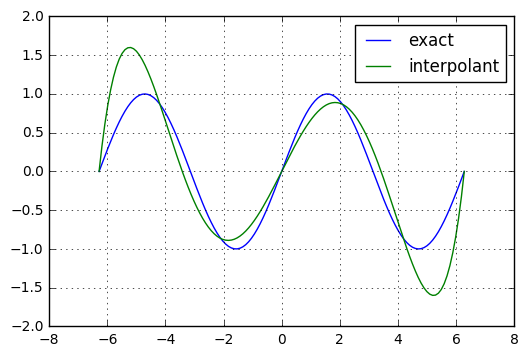

In [18]:
plt.grid('on'); plt.axis(ymin = -2, ymax = 2)
plt.plot(xg,yg, label="exact"); plt.plot(xg, ygi, label="interpolant")
plt.legend();

## Approach 2: cardinal basis $l_j$

* basis functions $$l_j(x) = \prod_{k\neq j} \frac{x-x_k}{x_j-x_k}$$

  * this forms a basis of the linear space of polynomials of degree $n$ if the $x_k$ are all distinct
  * collocation matrix is identity

* basis functions satisfy
  $$l_j(x_k) = \delta_{j,k}$$
  where $\delta_{j,k}$ is Kronecker delta

    * thus they are the solution of a special interpolation problem
  
* interpolation polynomial $$p_n(x) = \sum_{j=0}^n y_j l_j(x)$$

* no need to solve any equations!
* also called the *Lagrange form* of the interpolation polynomial

## Derivation of the Lagrangian (or cardinal) functions $l_j(x)$

* aim: compute $l_j(x)$, a polynomial of degree $n$ which satisfies $l_j(x_k) = \delta_{j,k}$

* property:   $l_j(x)$ is zero for all $x=x_k$ *except* $x=x_j$
* consequence:
    $$l_j(x) = c_j \prod_{k\neq j} (x-x_k)$$
    where the product is to be taken over all $k=0,\ldots,n$ *excluding* $k=j$

* property:   $$l_j(x_j) = c_j \prod_{k\neq j} (x_j-x_k) = 1$$
* consequence:
    $$c_j = \left(\prod_{k\neq j} (x_j - x_k)\right)^{-1}$$

## Example: linear interpolation

## Example -- cardinal functions

* for the data points

|  $i$  |  0  |  1  |   2  |
|:-----:|:---:|:---:|:----:|
| $x_i$ |  0  | 0.5 |   2  |
| $y_i$ | 0.2 | 0.6 | -1.0 |

the cardinal functions are

$$l_0(x) = \frac{(x-0.5)(x-2)}{(0-0.5)(0-2)} = (x-0.5)(x-2),$$ $$l_1(x) = \frac{(x-0)(x-2)}{(0.5-0)(0.5-2)} = -\frac{4}{3} x(x-2),$$ $$l_2(x) = \frac{(x-0)(x-0.5)}{(2-0)(2-0.5)} = \frac{1}{3} x(x-0.5).$$

## Example -- Lagrangian interpolant

$$p_2(x) = 0.2*l_0(x)+0.6*l_1(x)-l_2(x)$$

* verification:
    
    1. $p_2(x)$ has degree at most 2
    2. satisfies interpolation conditions

$$\begin{aligned}
p_n(x_j) &=& y_0 l_0(x_j) + \cdots + y_j l_j(x_j) + \cdots + y_n l_n(x_j) \\
&=& y_0 \cdot  0 + \cdots + y_j \cdot 1 + \cdots + y_n \cdot 0 \\
&=& y_j\end{aligned}$$

* uniqueness of this interpolant:

    * suppose $p(x)$ and $q(x)$ both satisfy collocation equations 
    * then $r(x) = p(x)-q(x)$ is a polynomial of degree at most $n$
    * and $r(x)$ has $n+1$ roots $x_0 \dots x_n$
    * thus $r(x)$ must be identically zero, and so $p=q$

-----------------------------------------------------

In [19]:
%%cython
import numpy as np
cimport numpy as np
def eval_lj(np.ndarray[np.float64_t,ndim=1] xpts, \
            np.ndarray[np.float64_t,ndim=1] xg):
    cdef int ng = xg.shape[0]
    cdef int npts = xpts.shape[0]
    cdef np.ndarray[np.float64_t,ndim=2] \
                    lj = np.ones((ng,npts))
    cdef int i
    cdef int j
    cdef int k
    for i in range(npts):
        for j in range(npts):
            if (i != j):
                for k in range(ng):
                    lj[k,i] *= (xg[k]-xpts[j])\
                              /(xpts[i]-xpts[j])
    return lj

---------------------------------------------------------------

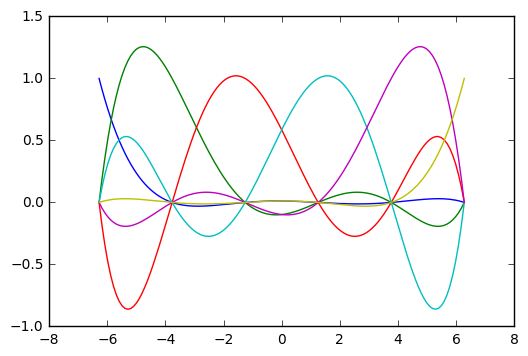

In [20]:
# Lagrangian or cardinal polynomials lj(x)
npts = 6; xpts = np.linspace(-2*pi,2*pi,npts)
ypts = uex(xpts); ng = 128; xg = np.linspace(-2*pi,2*pi,ng)
ljg = eval_lj(xpts,xg); 
for j in range(npts): plt.plot(xg,ljg[:,j])

------------------------------------------------

time for polynomial evaluation:
10000 loops, best of 1: 150 µs per loop


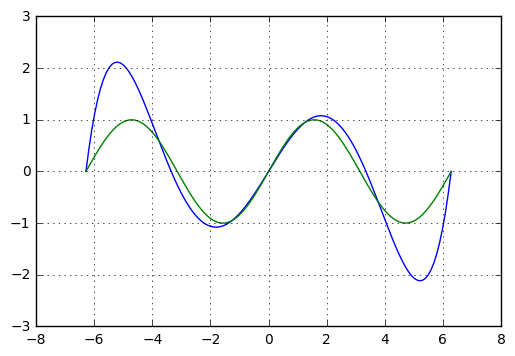

In [21]:
print('time for polynomial evaluation:')
%timeit -r 1 yg = np.dot(eval_lj(xpts,xg),ypts.T)
plt.plot(xg, np.dot(eval_lj(xpts,xg),ypts.T),xg,uex(xg)); plt.grid('on')

## Approach 3: Newton's basis $n_j(x)$

* basis functions $n_0(x)=1$ and $$n_{j+1}(x) = \prod_{k=0}^j (x-x_k)$$
    * collocation matrix is triangular

* interpolant for points $(x_0,y_0),\ldots,(x_k,y_k)$:
$$p_k(x) = \sum_{j=0}^k c_j n_j(x)$$
NB: the $c_j$ are independent of $k$!

* first polynomial $p_0(x) = y_0$
* recursion $$p_{k+1}(x) = p_k(x) + c_{k+1} n_{k+1}(x)$$
    * substituting $x=x_{k+1}$ to get $$c_{k+1} = \frac{y_{k+1}-p_k(x_{k+1})}{n_{k+1}(x_{k+1})}$$

## Example: linear interpolant

## Example Polynomial Interpolation

* same interpolation points

|  $i$  |  0  |  1  |   2  |
|:-----:|:---:|:---:|:----:|
| $x_i$ |  0  | 0.5 |   2  |
| $y_i$ | 0.2 | 0.6 | -1.0 |

* Newton's functions are $$\begin{aligned}
n_0(x)            & = 1, \\
n_1(x) & = x,\\
n_2(x) & = x(x-0.5)\end{aligned}$$
* and so $$\begin{aligned}
p_0(x)            & = 0.2, \\
p_1(x) & = 0.2 + 0.8 x,\\
p_2(x) & = 0.2 + 0.8 x - \frac{14}{15} x(x-0.5)\end{aligned}$$

## Evaluation of Newton polynomial with Horner-like method


In [22]:
def pnh(x,a,xk,n):
    y = a[-1]
    for k in range(n-2,-1,-1):
        y  = (x-xk[k])*y + a[k]
    return y

In [23]:
%%timeit
from numpy.random import random; n= 200; x = random(); \
               a = random(n); xk = np.linspace(0,1,n)
y = pnh(x,a,xk, n) # timing polynomial

1000 loops, best of 3: 327 µs per loop


-----------------------------------------------------

In [24]:
%%cython
# fast Newton polynomial evaluation with Horner's method
cimport numpy as np
import numpy as np

def pnhc(np.float64_t x, 
         np.ndarray[np.float64_t, ndim=1] a,
         np.ndarray[np.float64_t, ndim=1] xk):
    
    cdef np.float64_t y = 0.0
    n = a.shape[0]
    for k in range(n-1,-1,-1):
        y  = (x-xk[k])*y + a[k]
    return y

---------------------------

In [25]:
%%cython
# fast Newton polynomial evaluation with Horner's method
cimport numpy as np
import numpy as np
def pnhg(np.ndarray[np.float64_t, ndim=1] xg, \
         np.ndarray[np.float64_t,ndim=1] a,
         np.ndarray[np.float64_t,ndim=1] xk): 
    cdef int k
    cdef int ng = xg.shape[0]
    cdef int n  = a.shape[0]
    cdef np.ndarray[np.float64_t, ndim=1] \
                        yg = np.zeros(ng)
    for i in range(ng):
        for k in range(n-1,-1,-1):
            yg[i] = (xg[i]-xk[k])*yg[i] + a[k]
    return yg

-------------------------------

In [26]:
%%timeit
from numpy.random import random; n= 200; x = random(); \
      a = random(n); xk = np.linspace(0,1,n)
y = pnhc(x,a,xk) # timing polynomial

1000 loops, best of 3: 398 µs per loop


-------------------

In [27]:
%%cython
import numpy as np
cimport numpy as np

# compute the values of the Newton functions on some grid

def eval_nj(np.ndarray[np.float64_t,ndim=1] xpts, \
            np.ndarray[np.float64_t,ndim=1] xg):
        
    cdef int i, j, k
    cdef int ng = xg.shape[0]
    cdef int npts = xpts.shape[0]
    cdef np.ndarray[np.float64_t,ndim=2] \
                     nj = np.ones((ng,npts))
    for i in range(npts):
        for j in range(0,i):
            for k in range(ng):
                nj[k,i] *= (xg[k]-xpts[j])
    return nj

--------------------

In [28]:
# Newton polynomials lj(x)

s = 2
h = s

npts = 6
xpts = np.linspace(-s,s,npts)
ypts = uex(xpts)
ng = 129
xg = np.linspace(-s,s,ng)

njg = eval_nj(xpts,xg)

------------------------------------

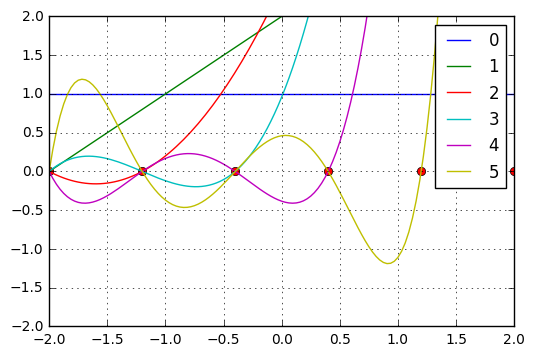

In [29]:
plt.plot(xpts,np.zeros(npts),'ro')
for j in range(npts): plt.plot(xg,njg[:,j],label=j)
plt.legend();plt.grid('on');plt.axis(ymin=-h,ymax=h);

--------------------------

In [30]:
%%cython
import numpy as np
cimport numpy as np
from __main__ import pnhc

def ncoeffs(np.ndarray[np.float64_t,ndim=1] xpts, \
            np.ndarray[np.float64_t,ndim=1] ypts):
    cdef int n = xpts.shape[0]
    cdef np.ndarray[np.float64_t, ndim=1] c = np.zeros(n)
    cdef int k
    c[0] = ypts[0]
    for k in range(n):
        c[k] = (ypts[k] - pnhc(xpts[k],c[:k],xpts[:k]))  \
                        / np.prod(xpts[k]-xpts[:k])
    return c

--------------------------------------------------------------------

In [31]:
%%timeit
from numpy.random import random; n= 200; \
    xpts = np.linspace(0,1,n); ypts = random(n)
c = ncoeffs(xpts, ypts)

10 loops, best of 3: 32.9 ms per loop


---------------------------------------------------

In [36]:
%%cython
import numpy as np
cimport numpy as np
def ncoeffs2(np.ndarray[np.float64_t,ndim=1] xpts, \
              np.ndarray[np.float64_t,ndim=1] ypts):
    cdef int k, i
    cdef np.float64_t qk, yi
    cdef int n = xpts.shape[0]
    cdef np.ndarray[np.float64_t,ndim=1] c = np.zeros(n)
    c[0] = ypts[0]
    for k in range(n):
        qk = 1.0
        for i in range(k):
            qk *= (xpts[k]-xpts[i])
        yi = 0.0
        for i in range(k-1,-1,-1):
            yi  = (xpts[k]-xpts[i])*yi + c[i]
        c[k] = (ypts[k] - yi)/qk
    return c

--------------------------------------------

In [37]:
%%timeit
from numpy.random import random; n= 200; \
    xpts = np.linspace(0,1,n); ypts = random(n)
c = ncoeffs2(xpts, ypts)

The slowest run took 346.33 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 246 µs per loop


---------------------------------------------

In [38]:
# computing the interpolant with Newton
# first we compute the coefficients
npts = 6
xpts = np.linspace(-2*pi,2*pi,npts)
ypts = uex(xpts)

ng = 127
xg = np.linspace(-2*pi,2*pi,ng)
yg = uex(xg)
#plt.plot(xg,yg)

%timeit c = ncoeffs2(xpts,ypts)
c = ncoeffs2(xpts,ypts)
%timeit yig = pnhg(xg, c, xpts)
yig = pnhg(xg, c, xpts)
# plt.plot(xg, yig);

100000 loops, best of 3: 12 µs per loop
The slowest run took 263.80 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 19.8 µs per loop


## Another example

* another illustration of how the same polynomial is represented in three different forms
* Consider the polynomial $p_3(x)=4x^3 +35x^2 -84x -954$ 
* Show that the four points with coordinates $(5,1)$, $(-7,-23)$, $(-6,-54)$ and $(0,-954)$ are on the graph of $p_3$

## Example - Newton’s Form

* the Newton functions are then $n_0(x)=1, \quad n_1(x)=x-5, \quad n_2(x)=(x-5)(x+7),\quad n_3(x)=(x-5)(x+7)(x+6)$
* An application of Newton’s interpolation method gives then $$p_3(x)=n_0(x)+2n_1(x)+3n_2(x)+4n_3(x)$$